In [27]:
import os 
import sys 
import pandas as pd 
import numpy as np
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn import tree
from six import StringIO
from IPython.display import Image 
import pydot
import pydotplus
sys.path.append('/Users/yantingting/PycharmProjects/modeling/')
import summary_statistics as ss
import metrics as mt 
import feature_selection as fs 
from feature_selection import *
import misc_utils as mu
from data_io_utils import *
import data_encryption as de
import plot_tools as pt 
import data_processing as dp 
import database_conncet as dc 
# 必须要在该界面设置中文的参数
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['font.sans-serif'] = ['STFangsong']

fs_obj = fs.FeatureSelection()
pf = mt.Performance()
bw = mt.BinWoe()

In [28]:
file_path = '/Users/yantingting/Seafile/风控/模型/10 印尼/202004 老客决策树/01 Data'
file_path_result ='/Users/yantingting/Seafile/风控/模型/10 印尼/202004 老客决策树/02 Result_0414(2)'
if not os.path.exists(file_path_result):
    os.mkdir(file_path_result)

# 数据读取和变量衍生

In [29]:
df_1 = load_data_from_pickle(file_path,'all_var.pkl')
df_1.rename(columns = {'dpd1':'label'}, inplace=True)
df_1['sample_flag'] = df_1['due_date'].apply(lambda x: 0 if x<pd.to_datetime('2020-04-01') else 1)
df_1 = df_1[df_1['label'].isin([0,1])]
df_1.shape
df_1.head()

(41107, 694)

,loan_id,effective_date,due_date,approved_period,late_day,label,age,monthly_salary,device_approval_ANDROID,device_approval_IOS,...,WizardPenyiapan_tfidf,Word_tfidf,YouTube_tfidf,com.android.fileexplorer.FileExplorerApplication_tfidf,com.mfashiongallery.emag_tfidf,maucash_tfidf,msa_tfidf,org.codeaurora.bluetooth_tfidf,tiket.com_tfidf,sample_flag
0,443078651486502912,2020-03-07,2020-04-04,29,3.0,1,51,8500000.0,1,0,...,0.0,0.00000,0.001200,0.00000,0.000000,0.016571,0.000000,0.000000,0.000000,1
1,443080428537413632,2020-03-07,2020-03-28,22,-1.0,0,24,0.0,1,0,...,0.0,0.00000,0.000595,0.00000,0.000000,0.000000,0.000000,0.005443,0.008149,0
2,443085055811223552,2020-03-07,2020-04-04,29,-1.0,0,24,4000000.0,0,1,...,0.0,0.00000,0.000734,0.00000,0.000000,0.000000,0.000000,0.006720,0.000000,1
3,443086227296919552,2020-03-07,2020-03-21,15,17.0,1,32,5000000.0,1,0,...,-1.0,-1.00000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,443092329594003456,2020-03-07,2020-03-28,22,10.0,1,30,2000000.0,1,0,...,0.0,0.00699,0.000758,0.00999,0.010407,0.000000,0.008853,0.006932,0.000000,0


In [30]:
var_dict = pd.read_excel(os.path.join(file_path,'dict_all.xlsx'))
# var_dict['指标类型'] = var_dict['数据源']
useless_cols = ['loan_id','effective_date','due_date','approved_period','late_day','sample_flag']
Y_col = 'label'
# X_col = list(set(df_1.columns).difference(useless_cols).difference([Y_col]))
# X_col = var_dict[var_dict['数据源']=='baseinfo']['指标英文'].tolist()
# X_col = var_dict[var_dict['数据源']!='izi']['指标英文'].tolist()
# X_col = var_dict[var_dict['数据源'].isin(['app','app_tfidf','app_freq'])]['指标英文'].tolist()
X_col = ['AdaKami',
'AdaPundi',
'Cairin',
'Cashcepat',
'Cashwagon',
'DanaRupiah',
'Easycash',
'Finmas',
'Indodana',
'KTA KILAT',
'KTAKILAT',
'Kredinesia',
'Kredit Pintar',
'KreditPintar',
'Pencarian',
'Pinjam Yuk',
'PinjamYuk',
'PinjamanGo',
'Rupiah Cepat',
'RupiahCepat',
'TunaiCepat',
'TunaiKita',
'Tunaiku',
'UKU',
'UangMe',
'maucash',
'AdaKami_tfidf',
'AdaPundi_tfidf',
'Cairin_tfidf',
'Cashcepat_tfidf',
'Cashwagon_tfidf',
'DanaRupiah_tfidf',
'Easycash_tfidf',
'Finmas_tfidf',
'Indodana_tfidf',
'KTA KILAT_tfidf',
'KTAKILAT_tfidf',
'Kredinesia_tfidf',
'Kredit Pintar_tfidf',
'KreditPintar_tfidf',
'Pencarian_tfidf',
'Pinjam Yuk_tfidf',
'PinjamYuk_tfidf',
'PinjamanGo_tfidf',
'Rupiah Cepat_tfidf',
'RupiahCepat_tfidf',
'TunaiKita_tfidf',
'Tunaiku_tfidf',
'UKU_tfidf',
'UangMe_tfidf',
'maucash_tfidf']
len(X_col)

51

# 拆分数据集

In [31]:
df_train = df_1[df_1['sample_flag'] == 0]
df_test = df_1[df_1['sample_flag'] == 1 ]              

X_train = df_train[X_col]
X_test= df_test[X_col]

y_train = df_train[Y_col]
y_test = df_test[Y_col]

Counter(y_train)
Counter(y_test)
print("X_train_shape:", X_train.shape, " y_train_shape:", y_train.shape)
print("X_test_shape:", X_test.shape,"  y_test_shape:", y_test.shape)

Counter({0: 18616, 1: 10162})

Counter({1: 5641, 0: 6688})

X_train_shape: (28778, 51)  y_train_shape: (28778,)
X_test_shape: (12329, 51)   y_test_shape: (12329,)


# Univariate Chart

In [32]:
# import time
# df_all = df_1
# feature_list = X_col
# time1 = time.time()
# wrong_list= []
# for index,value in enumerate(feature_list):
#     print(index,value)
#     try:
#         pt.univariate_chart(df = df_all.copy(), col = value , target ='label' , n = 5,
#                              special_attribute = [-1, np.nan],
#                              dftrain=df_train.copy(), dftest=df_test.copy(),
#                              draw_all=True, draw_train_test=True,result_path = file_path_result)
#     except Exception as e:
#         wrong_list.append(value)
#         print(e)
# wrong_list
# len(wrong_list)
# time2 = time.time()
# print('run_time: ', time2-time1)

# importance

In [33]:
from sklearn.metrics import accuracy_score

model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)
## prediction
y_pred = model.predict(X_test);
predictions = [round(value) for value in y_pred]
## evaluation
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

features_in_model = X_col
feature_importance = model.feature_importances_
var_importance = pd.DataFrame(columns=["指标英文", 'importance'])
var_importance['指标英文'] = features_in_model
var_importance['importance'] = feature_importance
var_importance.loc[:, 'importance_rank'] = var_importance.importance.rank(ascending=False)
var_importance.sort_values(by = 'importance',ascending = False).head()

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Accuracy: 53.55%


,指标英文,importance,importance_rank
49,UangMe_tfidf,0.068401,1.0
48,UKU_tfidf,0.063197,2.0
39,KreditPintar_tfidf,0.052172,3.0
46,TunaiKita_tfidf,0.052013,4.0
31,DanaRupiah_tfidf,0.051102,5.0


# overall_ranking

In [34]:
import time
result_path = file_path_result
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
args_dict = {
    'random_forest': {
        'grid_search': False,
        'param': None
    },
    'xgboost': {
        'grid_search': False,
        'param': None
    }
}
methods = [
    'random_forest',
    #'lasso',
    #'xgboost'
]

time1 = time.time()
## Train 分箱,为了得到分箱的woe值
X_cat_train, X_transformed_train, woe_iv_df, rebin_spec, ranking_result = fs_obj.overall_ranking(X_train, y_train,
                                                                                           var_dict, args_dict,
                                                                                           methods, num_max_bins=5)

woe_iv_df.to_excel(os.path.join(result_path,'woe_iv_df.xlsx'))
ranking_result.to_excel(os.path.join(result_path,'ranking_result.xlsx'))

rebin_spec = mu.convert_rebin_spec2XGB_rebin_spec(rebin_spec)
rebin_spec_bin_adjusted = {k: v for k, v in rebin_spec.items()}

bin_obj = mt.BinWoe()
X_cat_train = bin_obj.convert_to_category(X_train, var_dict, rebin_spec_bin_adjusted)
X_cat_test = bin_obj.convert_to_category(X_test, var_dict, rebin_spec_bin_adjusted)
print(1)

"""按训练集和验证集检查变量的稳定性和有效性"""
## train
df_train['appmon'] = '0_train'
df_test['appmon'] = '1_test'

all_cat = pd.concat([X_cat_train,X_cat_test])
app_data = pd.concat([df_train[['label','appmon']],df_test[['label','appmon']]])
X_cat_with_y_appmon_all = pd.merge(all_cat,app_data[['label','appmon']] ,left_index=True,right_index=True)
X_cat_with_y_appmon_all.shape

var_dist_badRate_by_time_all = ss.get_badRate_and_dist_by_time(X_cat_with_y_appmon_all,list([i for i in all_cat.columns if i != 'loan_id']),'appmon','label')
var_dist_badRate_by_time_all.to_excel(os.path.join(result_path, 'var_dist_badRate_by_sample.xlsx'))

# PSI
var_psi = pf.variable_psi(X_cat_train, X_cat_test, var_dict)
var_psi.loc[:, 'psi_rank'] = var_psi.PSI.rank(ascending=False)
var_psi.to_excel(os.path.join(result_path, 'var_PSI.xlsx'))

# 汇总各项指标
# var_psi.drop(['数据源','指标中文'],axis = 1,inplace=True)
ranking_result_all = ranking_result.merge(var_importance, on='指标英文', how='left').merge(var_psi, on='指标英文', how='left')
ranking_result_all.to_excel(os.path.join(result_path,'ranking_result_all.xlsx'))

time2 = time.time()
print('run_time: ', time2-time1)


/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1


'按训练集和验证集检查变量的稳定性和有效性'

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(41107, 53)

run_time:  25.13801383972168


# 变量筛选

In [42]:
time1 = time.time()
train = df_train.drop(useless_cols,axis = 1).drop('appmon',axis = 1)
test = df_test.drop(useless_cols,axis = 1).drop('appmon',axis = 1)

# train = df_train.drop(useless_cols,axis = 1)
# test = df_test.drop(useless_cols,axis = 1)
f_rmv = feature_remove(train,test, ranking_result_all, result_path, psi = 0.05, iv = 0.01, imp = 0, corr = 0.75, slope = 'False')

try:
    train = train.drop(['slope'], axis=1)
    test = test.drop(['slope'], axis=1)
except:
    pass

feature_used = list(set(X_col) - set(f_rmv))
len(feature_used)
X_train = df_train[feature_used]
X_test = df_test[feature_used]
time2 = time.time()
print('run_time: ', time2-time1)

变量总个数687
PSI筛掉的个数2
IV筛掉的个数0
xgb重要性筛掉的个数0
相关性特征筛掉的个数489
总共筛掉的个数489
剩余变量个数198


16

run_time:  52.89292907714844


# 调参数

In [43]:
# GridSearch
param_train1 = {'max_depth':range(1,7,1)} 
gsearch1 = GridSearchCV(estimator = tree.DecisionTreeClassifier(class_weight=None, criterion='gini',
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.02, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=1, splitter='best'),
                        param_grid = param_train1, scoring='roc_auc',n_jobs=4,iid=False,cv=6)
gsearch1.fit(X_train,y_train)
best_max_depth = gsearch1.best_params_['max_depth']
best_max_depth
#6

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


GridSearchCV(cv=6, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=0.02,
                                              min_samples_split=0.01,
                                              min_weight_fraction_leaf=0.0,
                                              presort=True, random_state=1,
                                              splitter='best'),
             iid=False, n_jobs=4, param_grid={'max_depth': range(1, 7)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='ro

5

In [44]:

param_train2 = {'min_samples_leaf':[i / 100.0 for i in range(0, 10)]} 
gsearch2 = GridSearchCV(estimator = tree.DecisionTreeClassifier(class_weight=None, criterion='gini',max_depth=best_max_depth,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=1, splitter='best'),
                       param_grid = param_train2, scoring='roc_auc',n_jobs=4,iid=False,cv=6)
gsearch2.fit(X_train,y_train)
best_min_samples_leaf = gsearch2.best_params_['min_samples_leaf']
best_min_samples_leaf
#0.01

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


GridSearchCV(cv=6, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=0.01,
                                              min_weight_fraction_leaf=0.0,
                                              presort=True, random_state=1,
                                              splitter='best'),
             iid=False, n_jobs=4,
             param_grid={'min_samples_leaf': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05,
                                              0.06, 0.07, 0.08, 

0.03

In [45]:

param_train3 = {'min_samples_split':[i / 100.0 for i in range(0, 20)]} 
gsearch3 = GridSearchCV(estimator = tree.DecisionTreeClassifier(class_weight=None, criterion='gini',max_depth=best_max_depth,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=best_min_samples_leaf,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=1, splitter='best'),
                       param_grid = param_train3, scoring='roc_auc',n_jobs=4,iid=False,cv=6)
gsearch3.fit(X_train,y_train)
best_min_samples_split = gsearch3.best_params_['min_samples_split']
best_min_samples_split
# 0.03

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


GridSearchCV(cv=6, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=0.03,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=True, random_state=1,
                                              splitter='best'),
             iid=False, n_jobs=4,
             param_grid={'min_samples_split': [0.0, 0.01, 0.02, 0.03, 0.04,
                                               0.05, 0.06, 0.07, 0.08

0.01

In [46]:

best_clf = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=best_max_depth,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=1, splitter='best')


best_clf.fit(X_train,y_train)

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.03, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=1, splitter='best')

# 可视化

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.03, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=1, splitter='best')

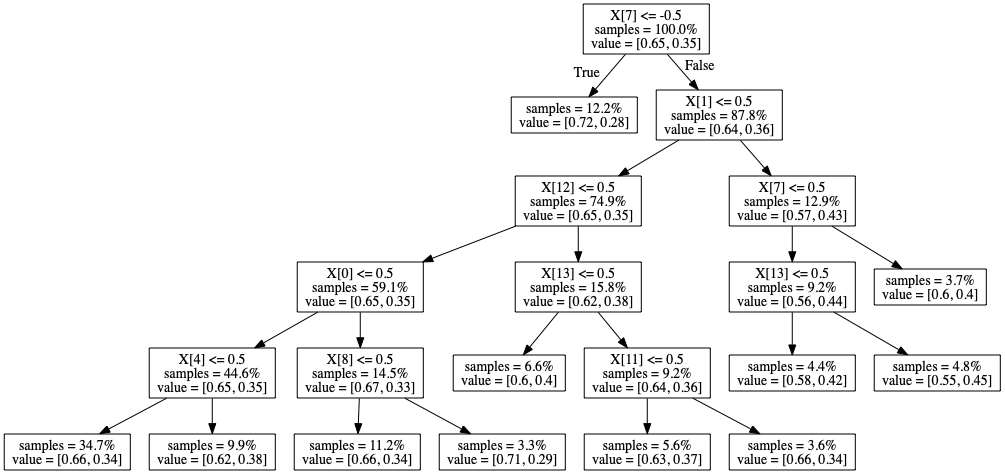

True

,指标英文,importance,importance_rank
7,Tunaiku,0.451510,1.0
1,PinjamYuk,0.313577,2.0
4,AdaKami,0.063652,3.0
12,Cairin,0.050466,4.0
13,TunaiKita,0.042933,5.0
8,Easycash,0.041434,6.0
0,Rupiah Cepat,0.024392,7.0
11,Cashwagon,0.012037,8.0
2,Kredinesia,0.000000,12.5
3,UangMe,0.000000,12.5


/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.03, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=1, splitter='best')

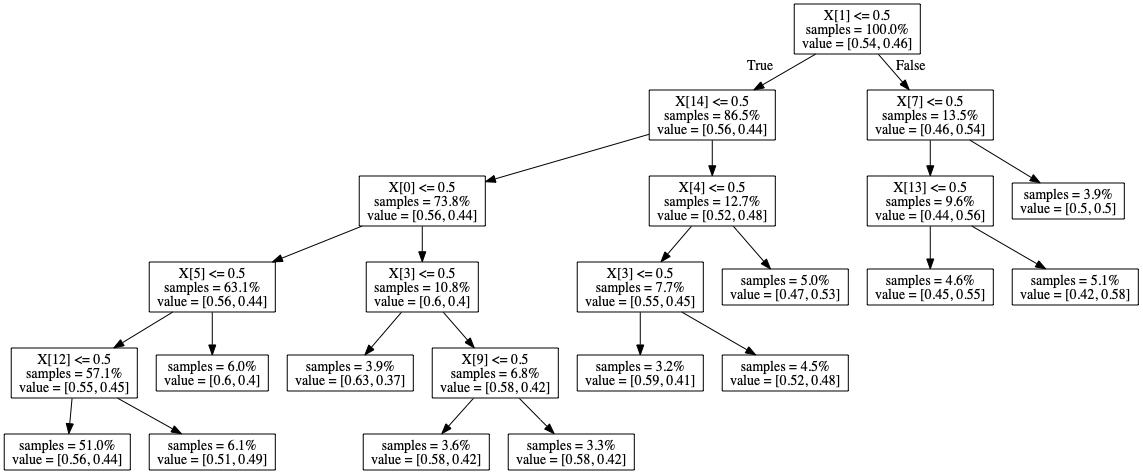

True

,指标英文,importance,importance_rank
1,PinjamYuk,0.507444,1.0
14,Cashcepat,0.089258,2.0
3,UangMe,0.079347,3.0
0,Rupiah Cepat,0.076347,4.0
4,AdaKami,0.075024,5.0
12,Cairin,0.059885,6.0
7,Tunaiku,0.055355,7.0
5,Indodana,0.045957,8.0
13,TunaiKita,0.011347,9.0
9,DanaRupiah,0.000036,10.0


In [47]:
var_tree = feature_used
var_rank = dict(zip(range(len(var_tree)+1),var_tree))
pd.DataFrame.from_dict(var_rank, orient='index').to_excel(os.path.join(file_path_result,'var_rank.xlsx'))
clf = best_clf

clf_train = clf.fit(X_train, y_train)
clf_train
dot_data = StringIO()  
tree.export_graphviz(clf_train, out_file=dot_data, proportion=True,
                     impurity = False,precision=2)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png()) 
graph.write_png(os.path.join(file_path_result , 'tree_train.png'))

features_in_model = feature_used
feature_importance = clf.feature_importances_
var_importance = pd.DataFrame(columns=["指标英文", 'importance'])
var_importance['指标英文'] = features_in_model
var_importance['importance'] = feature_importance
var_importance.loc[:, 'importance_rank'] = var_importance.importance.rank(ascending=False)
var_importance.sort_values(by = 'importance',ascending = False,inplace = True)
var_importance.to_excel(os.path.join(file_path_result,'var_importance_train.xlsx'))
var_importance.head(10)


# test
clf_test = clf.fit(X_test, y_test)
clf_test

dot_data = StringIO()  
tree.export_graphviz(clf_test, out_file=dot_data, proportion=True,
                     impurity = False,precision=2)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png()) 
graph.write_png(os.path.join(file_path_result , 'tree_test.png'))

features_in_model = feature_used
feature_importance = clf.feature_importances_
var_importance = pd.DataFrame(columns=["指标英文", 'importance'])
var_importance['指标英文'] = features_in_model
var_importance['importance'] = feature_importance
var_importance.loc[:, 'importance_rank'] = var_importance.importance.rank(ascending=False)
var_importance.sort_values(by = 'importance',ascending = False,inplace = True)
var_importance.to_excel(os.path.join(file_path_result,'var_importance_test.xlsx'))
var_importance.head(10)



# 结果

In [48]:
y_train_pred = best_clf.predict_proba(X_train)[:,1]
y_train_pred.shape
y_test_pred = best_clf.predict_proba(X_test)[:,1]
y_test_pred.shape
# ### 打分&KS
train_pred = df_train.copy()
train_pred['y_pred'] = y_train_pred

test_pred = df_test.copy()
test_pred['y_pred'] = y_test_pred
data_scored_train, train_proba_ks, train_proba_ks_20, train_score_ks, train_score_ks_20, data_scored_test, test_proba_ks, test_proba_ks_20, test_score_ks, test_score_ks_20 = pf.data_score_KS(train_pred, test_pred, 'y_pred',10,20)

writer = pd.ExcelWriter(os.path.join(file_path_result,'ks.xlsx'))
train_score_ks.to_excel(writer,sheet_name = 'train_score_ks')
test_score_ks.to_excel(writer, sheet_name = 'test_score_ks') 
writer.close()

# save_data_to_pickle(data_scored_train,file_path_result,'data_scored_train.pkl')
# save_data_to_pickle(data_scored_test,file_path_result,'data_scored_test.pkl')

def auc_acc_table(df):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import accuracy_score
    y = df.label.values
    y_pred = df.y_pred
    ## AUC
    auc = roc_auc_score(y, y_pred)
    print("auc: %.2f" % auc)
    ## Accuracy
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y, predictions)
    print("Accuracy: %.4f%%" % (accuracy * 100.0))
    return auc, accuracy

auc_train, acc_train = auc_acc_table(train_pred)
auc_test, acc_test = auc_acc_table(test_pred)
print('success')

(28778,)

(12329,)

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


auc: 0.52
Accuracy: 61.5505%
auc: 0.55
Accuracy: 55.7628%
success


# LiftChart

,order_no,Y,y_pred,score,score_bin,score_bin_20,proba_bin,proba_bin_20,sample_set
0,1,0.0,0.403533,611.0,"(609.0, 611.0]","(610.0, 611.0]","(0.366254, 0.403533]","(0.366254, 0.403533]",train
1,3,1.0,0.442712,607.0,"(601.0, 607.0]","(602.0, 607.0]","(0.420398, 0.442712]","(0.420398, 0.442712]",train
2,4,1.0,0.442712,607.0,"(601.0, 607.0]","(602.0, 607.0]","(0.420398, 0.442712]","(0.420398, 0.442712]",train
3,5,0.0,0.442712,607.0,"(601.0, 607.0]","(602.0, 607.0]","(0.420398, 0.442712]","(0.420398, 0.442712]",train
4,6,0.0,0.495798,600.0,"(597.0, 601.0]","(597.0, 601.0]","(0.493369, 0.527687]","(0.493369, 0.527687]",train


/Users/yantingting/PycharmProjects/modeling/plot_tools.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bkl_%s' % y_pred] = pd.qcut(df[y_pred], n_bins, duplicates='drop')
/Users/yantingting/PycharmProjects/modeling/plot_tools.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bkl_%s' % y_pred] = pd.qcut(df[y_pred], n_bins, duplicates='drop')


分箱数量:  6
分箱数量:  5


/Users/yantingting/PycharmProjects/modeling/plot_tools.py:83: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
/Users/yantingting/PycharmProjects/modeling/plot_tools.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)


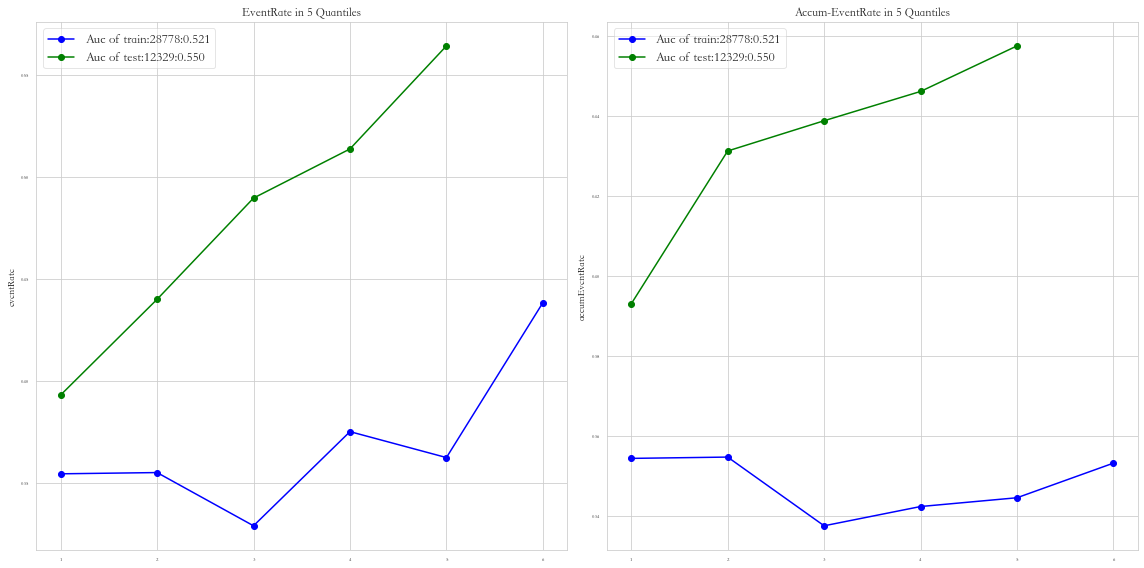

end


In [49]:
data_scored_train['sample_set'] = "train"
data_scored_test['sample_set'] = "test"
data_scored_all = pd.concat([data_scored_train, data_scored_test])
data_scored_all['order_no'] = data_scored_all['order_no'].astype(str)
data_scored_all.head()
save_data_to_pickle(data_scored_all,file_path_result,'data_scored_all.pkl')

FIG_PATH = os.path.join(file_path_result, 'figure', 'liftchart')
if not os.path.exists(FIG_PATH):
    os.makedirs(FIG_PATH)

train_lc = pt.show_result_new(data_scored_all.loc[data_scored_all.sample_set == 'train'], 'y_pred','Y', n_bins = 10, feature_label='train')
test_lc = pt.show_result_new(data_scored_all.loc[data_scored_all.sample_set == 'test'], 'y_pred','Y', n_bins = 10, feature_label='test')
# oot_lc = pt.show_result_new(data_scored_all.loc[data_scored_all.sample_set == 'oot'], 'y_pred','Y', n_bins = 10, feature_label='oot')
path = os.path.join(FIG_PATH, "LiftChart.png")
plt.savefig(path, format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()
plt.close()

print('end')